# Data

In [220]:
import numpy as np
import pandas as pd
import yfinance
import kaggle.api as kaggle
import matplotlib.pyplot as plt

from tempfile import gettempdirb
from pathlib import Path

# Download Air Passenger 
download_file_path = Path(gettempdir()) / 'AirPassengers.csv'
kaggle.authenticate()
kaggle.dataset_download_files('rakannimer/air-passengers', download_file_path.parent, unzip=True)

air_df = pd.read_csv(download_file_path, index_col=0)
air_df.index = pd.to_datetime(air_df.index)
display(air_df.head())

# Get SKHynix and SOX (필라델피아 반도체 지수)
skhynix = yfinance.Ticker('000660.KS')
skhynix = skhynix.history(period='5y')
skhynix.index = pd.to_datetime(skhynix.index)

sox = yfinance.Ticker('^SOX')
sox = sox.history(period='5y')
sox.index = pd.to_datetime(sox.index)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Normalized Data

<AxesSubplot:xlabel='Date'>

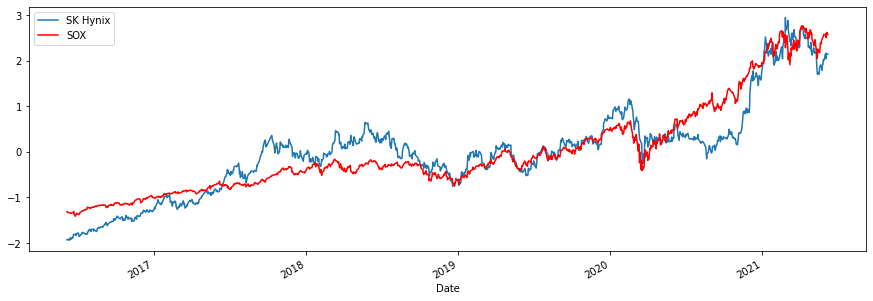

In [221]:
def normalize(df):
    price = df[['Close']]
    return (price - price.mean())/price.std()

fig, subplots = plt.subplots(1, figsize=(15, 5))

normalize(skhynix).plot(y='Close', label='SK Hynix', ax=subplots)
normalize(sox).plot(y='Close', label='SOX', color='red', ax=subplots)

# Non-Stationary Processes 

## Formula

Stationary 이미 ARIMA 글에서 무엇인지 정의했습니다.  따라서 본 글에서 다시 설명하지 않겠습니다.<br>
짧게 설명하면, time series에서 평균, 분산, 공분산값이 변하지 않고 일정한것이 특징입니다. <br> 

반대로 non-stationary  데이터의 경우는 기본적으로 예측이 매우 어렵습니다. <br> 
따라서 non-stationary 데이터를 stationary 데이터로 변경해줄 필요가 있습니다. 

아래는 non-stationary 데이터 패턴은 다음과 같습니다. 

![](images\non-stationary01.png)

Non-stationary process 의 타입은 다음과 같습니다. 

![](images\non-stationary02.png)



1.  완전 Random Walk : $ Y_t = Y_{t-1} + \epsilon_t  $
    - 완전 랜덤 워크는 바로 이전 시간의 값에서 stochastic 값을 더합니다. 
    - 랜덤 워크는 process with a unit order 또는 process with a stochastic trend 라고도 함 
2. Random Walk with Drift: $ Y_t = \alpha + Y_{t-1} + \epsilon_t $
    - 랜덤워크는 동일한데 여기서 Trend 상수값이 더해진 것 입니다. 
3. Deterministic Trend: $ Y_t = \alpha + Y_{t-1} + \beta_t + \epsilon_t $
    - 종종 random walk with drift 와 혼동됨
    - random walk with drift 와 마찬가지로 drift ($ \alpha $) 그리고 white noise ($ \epsilon$) 를 갖고 있음
    - 바로 이전 시계열 데이터 ($ Y_{t-1} $) 에서 영향을 받는게 아니라 $ \beta_t $ 에 고정값에 영향을 받습니다.
4. Random Walk with Drift and Deterministic Trend: $ Y_t = \alpha + Y_{t-1} + \beta_t + \epsilon_t $

## Differencing

Random walk 를 stationary data 로 바꿔주는 과정을 differencing 이라고 합니다. <br> 
공식은 아래와 같습니다.

$$ Y_t - Y_{t-1} $$

 - Differencing Random Walk : $ Y_t - Y_{t-1} = \epsilon_t $
 - Differencing Random Walk with Drift: $ Y_t - Y_{t-1} = \alpha + \epsilon_t $
 - Detrending Deterministic Trend: $ Y_t - \beta_t = \alpha + \epsilon_t $
 
![](images\non-stationary03.png)

## Detrending 

Deterministic Trend의 경우 trend를 제거해줌으로서 stationary 데이터로 만들어 줄 수 있습니다. 

$$ Y_t - \beta_t $$

![](images\non-stationary04.png)

# Unit Root

## Explained 

단위근 검정 (unit root test)는 non-stationary data에  **차분(Differencing) 이 필요할지 결정하기 위해 사용**하며, <br>
기술적으로 **alpha = 1 일 경우 unit root이 존재하며, 의미는 해당 time-series가 non-stationary 라는 뜻**입니다. 

 - $ H_0 $ 귀무가설: $ \alpha = 1 $ | unit root 가 존재한다. 즉 데이터는 non-stationary이며 p = 1 이다. 
 - $ H_1 $ 대립가설: $ \alpha \lt 1 $ | stationary data이다. 

$$ Y_t = \alpha Y_{t-1} + \beta X_e + \epsilon_t $$

 - $ X_e $ : exogenous variable. $ Y_t $ 를 설명해주는 외부 변수 데이터











$$ \begin{align}
y_t &= \alpha y_{t-1} + \epsilon_t  \\
y_{t-1} &= \alpha y_{t-2} + \epsilon_{t-1} 
\end{align} $$

두번째 공식을 첫번째 공식에 대입하면 다음과 같아집니다. 

$$ \begin{align}
y_t &= \alpha \left[ \alpha y_{t-2} + \epsilon_{t-1}  \right] + \epsilon_t  \\
y_t &= \alpha^2 y_{y-2} + (\alpha^1) \epsilon_{t-1} + (\alpha^0) \epsilon_t
\end{align} $$

위에 대입한것처럼 계속 해서 해나가면 다음과 같이 됩니다.

$$ \begin{align}
y_t &= \alpha^n y_{t-n} + \sum^{n-1}_{i=1} \alpha^i \epsilon_{t-i}
\end{align} $$

만약 $ \alpha = 1 $ 이라면 첫번째 항은 $ y_{t-n} $ 이 되고, 두번째 항은 단순히 모든 error 값들의 합이 됩니다. <br>
즉 Variance는 $  n \times E\left[ e_t \right]^2 $ 가 됩니다. <br>
설명하면 variance의 값은 계속 늘어나는 형태가 되며, limit으로 따지면 무한대가 됩니다. 


이 경우 Heteroskedasticity (에러 variane값이 실제 관측값과 맞지 않는 현상) 때문에 regression을 할 수 없게 됩니다. <br>
예를 들어서 OLS (Ordinary Least Squares) 의 경우 variance값이 constant라는 가정을 하는데.. 이 가정이 깨지게 됩니다.

따라서 unit root을 갖고 있는 시계열 데이터의 경우 <br>
차분 (Differencing) 같은 방법을 통해서 stationary data 로 변경해 줘야 합니다. 


# Augmented Dickey Fuller Test 

 - $ H_0 $ : unit root 존재. -> non-stationary data 
 - $ H_1 $ : unit root 존재하지 않음 -> stationary data


## Statsmodels

 - **statistic**: 음수가 나올수록 귀무가설을 기각. -> stationary dataset 이라는 뜻 
 - **p-value** 
     - p-value > 0.05: $ H_0 $ 귀무가설을 기각시키는데 실패 -> unit root 존재 / non-stationary data
     - p-value <= 0.05 : $ H_0 $ 귀무가설을 기각시킴  -> unit root 존재X / stationary data
 - **critical values 1% 5% 10%**
     - significance level 을 의미함 
     - statistic 값과 비교해서 보면 되며, statistic 값이 1%, 5%, 10% 보다 낮을 경우 해당 유의수준으로 귀무가설을 기각

<AxesSubplot:>

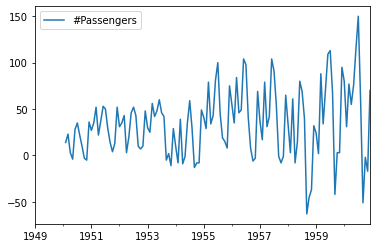

In [334]:
diff = air_df - air_df.shift(13)
diff.plot()

In [330]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(air_df, regression='ctt', autolag='AIC')

adf_result_df = pd.DataFrame({
    'statistic': [adf_result[0]],
    'p_value': [adf_result[1]],
    'n_lags': [adf_result[2]],
    'n_obs': [adf_result[3]],
    'icbest': [adf_result[5]],
    **adf_result[4]
}).round(2)
adf_result_df

,statistic,p_value,n_lags,n_obs,icbest,1%,5%,10%
0,-3.23,0.2,13,130,988.81,-4.46,-3.88,-3.58


# Cointegration Test

Cointegraion Test 는 장기간에 걸친 time series 에서 상관관계가 있는지 체크 하는데 사용합니다. 

 

## Unit Root 

Unit root process 또는 difference stationary process라고 부르며, <br>
시계열상에서의 stochastic trend (random walk with drift) 입니다. 
